In [1]:
import pandas as pd

In [4]:
df = pd.read_excel("User Feedback App My IndiHome.xlsx", sheet_name="App Store")

In [5]:
df

,date,timestamp,userName,title,review,rating,isEdited,response_id,response_body,response_modified,sentiment,Kategori
0,2024-08-01,5:06:00,Indihomoasqw,Internet asw kalobisa bintang 0 ganguan trus t...,Gakjelas banget anjg gabguan 1 minggu udh 2x +...,1,False,45913045.0,"Dear Pelanggan yang terhormat, mohon maaf atas...",12-08-2024 3:22:15,Negatif,Kualitas Internet
1,2024-08-01,5:58:00,bale0709,LELET,Sering gangguan dan lelet,1,False,45913049.0,"Dear Pelanggan yang terhormat, mohon maaf atas...",12-08-2024 3:22:20,Negatif,Kualitas Internet
2,2024-08-02,0:05:00,Rzrangerz,Gangguan terus,Belakangan ini sering gangguan,1,False,45913050.0,"Dear Pelanggan yang terhormat, mohon maaf atas...",12-08-2024 3:22:24,Negatif,Kualitas Internet
3,2024-08-02,4:45:00,Jecly's,Sampah,Aplikasi SAMPAH. Selalu minta muat ulang untuk...,1,True,43859022.0,"Dear Pelanggan yang terhormat, mohon maaf atas...",13-05-2024 03:30:19,Negatif,Usability & Reliability Apps
4,2024-08-02,5:10:00,Jarguh,Fitur Pengaduan gak jelas,"Fitur pengaduan gk jelas, masak mau pengaduan ...",1,False,45913146.0,"Dear Pelanggan yang terhormat, mohon maaf atas...",12-08-2024 3:27:19,Negatif,Usability & Reliability Apps
...,...,...,...,...,...,...,...,...,...,...,...,...
358,2024-11-24,01:03:57,B0cIL EpEp,aplikasi tolol,diminta login trs di arahin ke my telkomsel.. ...,1,False,NaN,NaN,NaN,Negatif,Usability & Reliability Apps
359,2024-11-24,02:29:40,azzam321,Tidak berguna,"Ini ITnya tolol apa gimana, aplikasinya tidak ...",1,False,NaN,NaN,NaN,Negatif,Usability & Reliability Apps
360,2024-11-25,01:48:21,hapsarimandala,Download aplikasi ini itu biar lapor gangguan ...,Download aplikasi ini itu supaya bisa lapor ga...,1,False,NaN,NaN,NaN,Negatif,Usability & Reliability Apps
361,2024-11-25,08:13:24,sovereign007zigzag,BAD CS,agen sedang mengetik… ternyata gimik,1,False,NaN,NaN,NaN,Negatif,Customer Service


In [6]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import numpy as np
import re
import nltk
import warnings
import tensorflow as tf
warnings.filterwarnings("ignore")

import seaborn as sns
import matplotlib.pyplot as plt

from textblob import TextBlob
from nltk.corpus import stopwords

import string
import json

from nltk.corpus import stopwords
# indo = stopwords.words('indonesian')

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from wordcloud import WordCloud, STOPWORDS

nltk.download('punkt')
nltk.download('stopwords')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.2.3) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/gibranariq/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gibranariq/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
df['gram'] = df['review'].str.lower()
df['gram'] = df['review'].str.replace(r'\bga\b', 'tidak', regex=True)
df['gram'] = df['gram'].str.replace(r'\bngga\b', 'tidak', regex=True)
df['gram'] = df['gram'].str.replace(r'\bgak\b', 'tidak', regex=True)
df['gram'] = df['gram'].str.replace(r'\bg\b', 'tidak', regex=True)
df['gram'] = df['gram'].str.replace(r'\bga\b', 'tidak', regex=True)

In [8]:
df['gram'] = df['gram'].astype(str)

In [9]:
def find_word_positions(text, words):
    positions = {word: {'awal': False, 'tengah': False, 'akhir': False} for word in words}

    for word in words:
        # Awal kalimat
        if re.search(r'(^|\.\s|\?\s|\!\s)' + re.escape(word) + r'(\s|$)', text):
            positions[word]['awal'] = True
        # Tengah kalimat
        if re.search(r'(\s)' + re.escape(word) + r'(\s)', text):
            positions[word]['tengah'] = True
        # Akhir kalimat
        if re.search(r'(\s)' + re.escape(word) + r'($|\.\s|\?\s|\!\s)', text):
            positions[word]['akhir'] = True

    return positions

def clean_text(text):
    # Menghapus emoji
    emoji_pattern = r'[\U0001F600-\U0001F64F|\U0001F300-\U0001F5FF|\U0001F680-\U0001F6FF|\U0001F1E0-\U0001F1FF|\U00002702-\U000027B0|\U000024C2-\U0001F251|\U0001f926-\U0001f937|\U00010000-\U0010ffff|\u2640-\u2642|\u2600-\u2B55|\u200d|\u23cf|\u23e9|\u231a|\ufe0f|\u3030]'
    text = re.sub(emoji_pattern, '', text)

    text = text.lower() # Mengonversi ke lowercase
    text = re.sub(r'\d+', '', text) # Menghapus angka
    text = re.sub(r'#\\w+', '', text) # Menghapus hashtag
    text = re.sub(r'\[^A-Za-z0-9 \]', '', text) # Menghapus karakter non-alfanumerik
    text = re.sub(r'\\s+', ' ', text) # Menghapus spasi berlebihan

    normalization_dict = normalization_dict = {' aplilasi ':' aplikasi ', ' apk ': ' aplikasi ', ' app ': ' aplikasi '}
    for norm in normalization_dict:
        text = text.replace(norm, normalization_dict[norm])

    text = text.split() # Memisahkan teks menjadi kata-kata
    unique_words = set() # Inisialisasi set untuk menyimpan kata-kata yang sudah muncul

    stemmer = StemmerFactory().create_stemmer()
    list_stopwords = []
    # Memuat daftar stopwords untuk bahasa Indonesia dan bahasa Inggris
    stop_words_indonesian = set(stopwords.words('indonesian'))
    stop_words_english = set(stopwords.words('english'))
    stopwords_to_add = [
        'aja', 'ada', 'aja', 'antri', 'apa', 'ayo', 'sangat', 'dong', 'eh', 'gmn','da','ka','refresh','sampe','semalem','beli','ng','wkwkwk','gadibalikin','kakak','butuh','obat','aktif','realitanya','murni','kamar','booster','lu','si','ttp','adu','yah','sore','pagi','siang','malam','malem','adu','skrg','krn','td','tiang','thank','gue','trs','maaf'
        'halah', 'ini', 'iya', 'jalan', 'kali', 'kalau', 'kamu', 'kau', 'kita', 'kok', 'kalo','ros','amp','kak','teh','gbkapan','tgl','malam','mbps','detik','emg','emng','pagi','kemarin','kemaren','dm','rang','tks','bodoh','brapa',
        'ke', 'kita', 'lo', 'mau', 'min', 'nanti', 'nggak', 'ni', 'nih', 'nya', 'oke', 'punya','ken','admin','urgent','kaka','admin','tidur','ditgl','ne','ubah','limpah','bumn','gbr','ya','x','lanciaoooo','selamat',
        'saat', 'sama', 'saja', 'sana', 'sih', 'tapi', 'tidak', 'tolong', 'tp','apa','woi','kait','gua','loh','brp','menit','hari','tanggal','curi','ngefek','becus','bumn','tlg','tuh','korupsi','becus','gw','yah','fortnite','console','xbox','mohon','terimakasih',
        'tuk', 'udah', 'utk', 'ya', 'yang', 'yuk', 'gk', 'tdk', 'b', 'dng', 'pa', 'tp', 'x', 'lg', 'bgt', 'g', 'sdh', 'klo', 'yaa', 'un', 'nj','aju','ajuin','gbr','kak','sih','tidur','lelap','indihome','lu','si','abdull' ,'aamiin' ,'aaaaaaaa' ,'aaaa',
        'jgn', 'ok', 'ueu', 'p', 'nya', 'kyak', 'anj', 'gimana', 'gin', 'kend', 'mintak', 'aga', 'dpt', 'bca', 'gg', 'dr', 'looyyyttb', 'yg', 'ngga', 'cek','myindihome','jg','deh','ya','apa','mengerti','ya','wa','sih','ko','terima','kasih',
        'dgn', 'e', 'udh', 'bsa', 'trus', 'mesti', 'mulu', 'bener', 'dah', 'bs', 'jd', 'cs', 'tau', 'emang', 'gas', 'jam', 'blm', 'gitu', 'dapet', 'biar', 'kayak', 'kaya', 'dll','speed','refreshment','indihome','sy','buset','yourindihome','sod','uang',
        "coba", "bayangin", "ganggu", "hei", "kawan", "ku", "lupa", "juang", "capek","pas", "makan", "nanganin", "dinyalain", "speedtest", "pakai", "ambil", "pilih","internet", "skrng", "langgan", "speedd", "internet", "aplikasi", "halo", "riwayat", "transaksi", "demand", "realisasi", "kerja", "proses"
    ]

    list_stopwords.extend(stop_words_indonesian)
    list_stopwords.extend(stop_words_english)
    list_stopwords.extend(stopwords_to_add)
    list_stopwords = list(dict.fromkeys(list_stopwords))

    # Menghapus stopwords, melakukan stemming, dan menghindari pengulangan kata yang sama
    cleaned_words = []
    word_positions = find_word_positions(' '.join(text), stopwords_to_add)
    for word in text:
        if word not in list_stopwords:
            stemmed_word = stemmer.stem(word)
            if stemmed_word not in unique_words:
                unique_words.add(stemmed_word)
                cleaned_words.append(stemmed_word)

    # Menggabungkan kembali kata-kata menjadi teks yang sudah dibersihkan
    cleaned_text = ' '.join(cleaned_words)

    return cleaned_text, word_positions

def clean_dataframe(df, text_column):
    df[text_column] = df[text_column].apply(lambda x: clean_text(x)[0])  # Only return the cleaned text
    return df

In [10]:
import time

start_time = time.time()

# Your function call
df = clean_dataframe(df, 'gram')

end_time = time.time()

# Print the execution time
print(f"Execution time: {end_time - start_time} seconds")

Execution time: 98.32980179786682 seconds


In [11]:
import time

start_time = time.time()

# Your function call
df = clean_dataframe(df, 'gram')

end_time = time.time()

# Print the execution time
print(f"Execution time: {end_time - start_time} seconds")

Execution time: 88.76231408119202 seconds


In [12]:
df['gram'] = df['gram'].replace('lot', 'lemot', regex=True)
df['gram'] = df['gram'].replace('loss', 'los', regex=True)
df['gram'] = df['gram'].replace('bom', 'belum', regex=True)
df['gram'] = df['gram'].replace('layan', 'pelayanan', regex=True)
df['gram'] = df['gram'].replace('jaring', 'jaringan', regex=True)
df['gram'] = df['gram'].replace('tagih', 'tagihan', regex=True)

In [13]:
df.to_csv('test_gram1.csv',index=False)

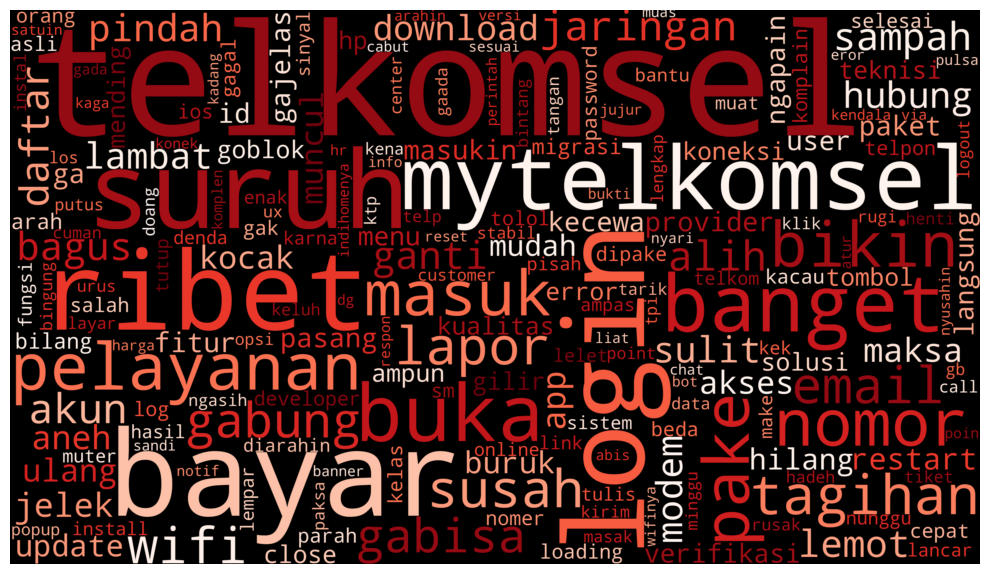

In [14]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

def plot_cloud(wordcloud):
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Assuming df is your dataframe and 'gram' is the column containing the words
all_words = ' '.join([tweets for tweets in df['gram']])

wordcloud = WordCloud(
    width=7000,
    height=4000,
    random_state=3,
    background_color='black',
    colormap='Reds',
    collocations=False,
    stopwords=STOPWORDS
).generate(all_words)

plot_cloud(wordcloud)


In [15]:
def generate_ngram(n=2,df=df,df_col_name='gram'):
    c_vec = CountVectorizer(ngram_range=(n,n))
    # matrix of ngrams
    ngrams = c_vec.fit_transform(df['gram'])
    # count frequency of ngrams
    count_values = ngrams.toarray().sum(axis=0)
    # list of ngrams
    vocab = c_vec.vocabulary_
    df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
                ).rename(columns={0: 'frequency', 1:f'{n}-gram'})
    return df_ngram


In [16]:
bigram_df = generate_ngram(n=2)
bigram_df

,frequency,2-gram
0,8,bayar tagihan
1,7,telkomsel ribet
2,7,restart modem
3,7,pindah telkomsel
4,7,bikin ribet
...,...,...
2214,1,account try
2215,1,accnya graparinya
2216,1,acc alat
2217,1,abis lagiii


In [17]:
trigram_df = generate_ngram(n=3)
trigram_df

,frequency,3-gram
0,3,telkomsel bikin ribet
1,3,bayar tagihan sulit
2,2,telkomsel suruh masukin
3,2,telkomsel lawak banget
4,2,tagihan arah telkomsel
...,...,...
2065,1,accnya graparinya acc
2066,1,acc alat pasang
2067,1,abis update muncul
2068,1,abis update login


In [18]:
fourgram_df = generate_ngram(n=4)
fourgram_df

,frequency,4-gram
0,2,bayar tagihan arah telkomsel
1,1,zaman tempoe doeloe pulsa
2,1,yooo tutorial belah letak
3,1,yaudah salahin konsumen ga
4,1,wkwk masukin kode otp
...,...,...
1782,1,accnya graparinya acc alat
1783,1,acc alat pasang teknisi
1784,1,abis update muncul notif
1785,1,abis update login akun


In [19]:
bigram_df.to_csv('bigram1.csv',index=False)
trigram_df.to_csv('trigram1.csv',index=False)
fourgram_df.to_csv('fourgram1.csv',index=False)